In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 读取两个CSV文件
mod_df = pd.read_csv('特征和密度结果_MODIS_MOD09GA_061_20241106_插值填充_tuoshan2.csv')
mcd_df = pd.read_csv('特征和密度结果_MODIS_MCD18C2_061_20241104_插值填充_tuoshan.csv')

# 重命名MCD数据框中的密度列,以区分来源
mcd_df = mcd_df.rename(columns={
    'density_mean': 'density_mean_mcd',
    'density_lower': 'density_lower_mcd', 
    'density_upper': 'density_upper_mcd'
})

# 重命名MOD数据框中的密度列
mod_df = mod_df.rename(columns={
    'density_mean': 'density_mean_mod',
    'density_lower': 'density_lower_mod',
    'density_upper': 'density_upper_mod'
})

# 合并两个数据框,以date为键
merged_df = pd.merge(mod_df, mcd_df, on='date')

# 计算两个来源的平均值作为最终密度值
merged_df['density_mean'] = merged_df['density_mean_mod']
merged_df['density_lower'] = merged_df['density_lower_mod']
merged_df['density_upper'] = merged_df['density_upper_mod']


In [2]:
# pip install seaborn -i https://mirrors.aliyun.com/pypi/simple/

In [3]:
# pip install keras-tcn  -i https://mirrors.aliyun.com/pypi/simple/


density_mean 与各特征的相关性排序:
ndvi: 0.2234
GMT_0900_PAR: 0.2196
FAI: 0.2186
GMT_0000_PAR: 0.1571
GMT_1200_PAR: nan
GMT_1500_PAR: nan
GMT_1800_PAR: nan
PPDI: 0.1699
DAPAR: 0.1347
PDVI: 0.1195
GMT_0600_PAR: 0.1181
GMT_0300_PAR: 0.0865
b2: 0.0782
b4: 0.0646
MPAR: 0.0644
b5: 0.0636
b3: 0.0612
b1: 0.0575
nrfi: -0.0427
GMT_2100_PAR: 0.0353
APAR: 0.0353
b7: -0.0319
PAI: 0.0301
evi: -0.0144
b6: 0.0108
ndci: -0.0087

density_lower 与各特征的相关性排序:
GMT_0900_PAR: 0.1645
ndvi: 0.1590
FAI: 0.1464
GMT_0000_PAR: 0.1224
b2: 0.0854
GMT_1200_PAR: nan
GMT_1500_PAR: nan
GMT_1800_PAR: nan
PPDI: 0.1441
DAPAR: 0.0981
PDVI: 0.0864
GMT_0600_PAR: 0.0801
b4: 0.0777
b3: 0.0749
b5: 0.0742
b1: 0.0729
GMT_0300_PAR: 0.0628
ndci: -0.0538
MPAR: 0.0428
b6: 0.0346
nrfi: 0.0161
PAI: -0.0134
b7: -0.0041
evi: 0.0028
GMT_2100_PAR: -0.0009
APAR: -0.0009

density_upper 与各特征的相关性排序:
FAI: 0.2446
ndvi: 0.2432
GMT_0900_PAR: 0.2428
GMT_0000_PAR: 0.1696
nrfi: -0.0821
GMT_1200_PAR: nan
GMT_1500_PAR: nan
GMT_1800_PAR: nan
PPDI: 0.1745
DAPAR: 0.

/tmp/ipykernel_17714/1750480707.py:36: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17714/1750480707.py:36: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17714/1750480707.py:36: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17714/1750480707.py:36: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17714/1750480707.py:36: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17714/1750480707.py:36: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_17714/1750480707.py:36: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  plt.

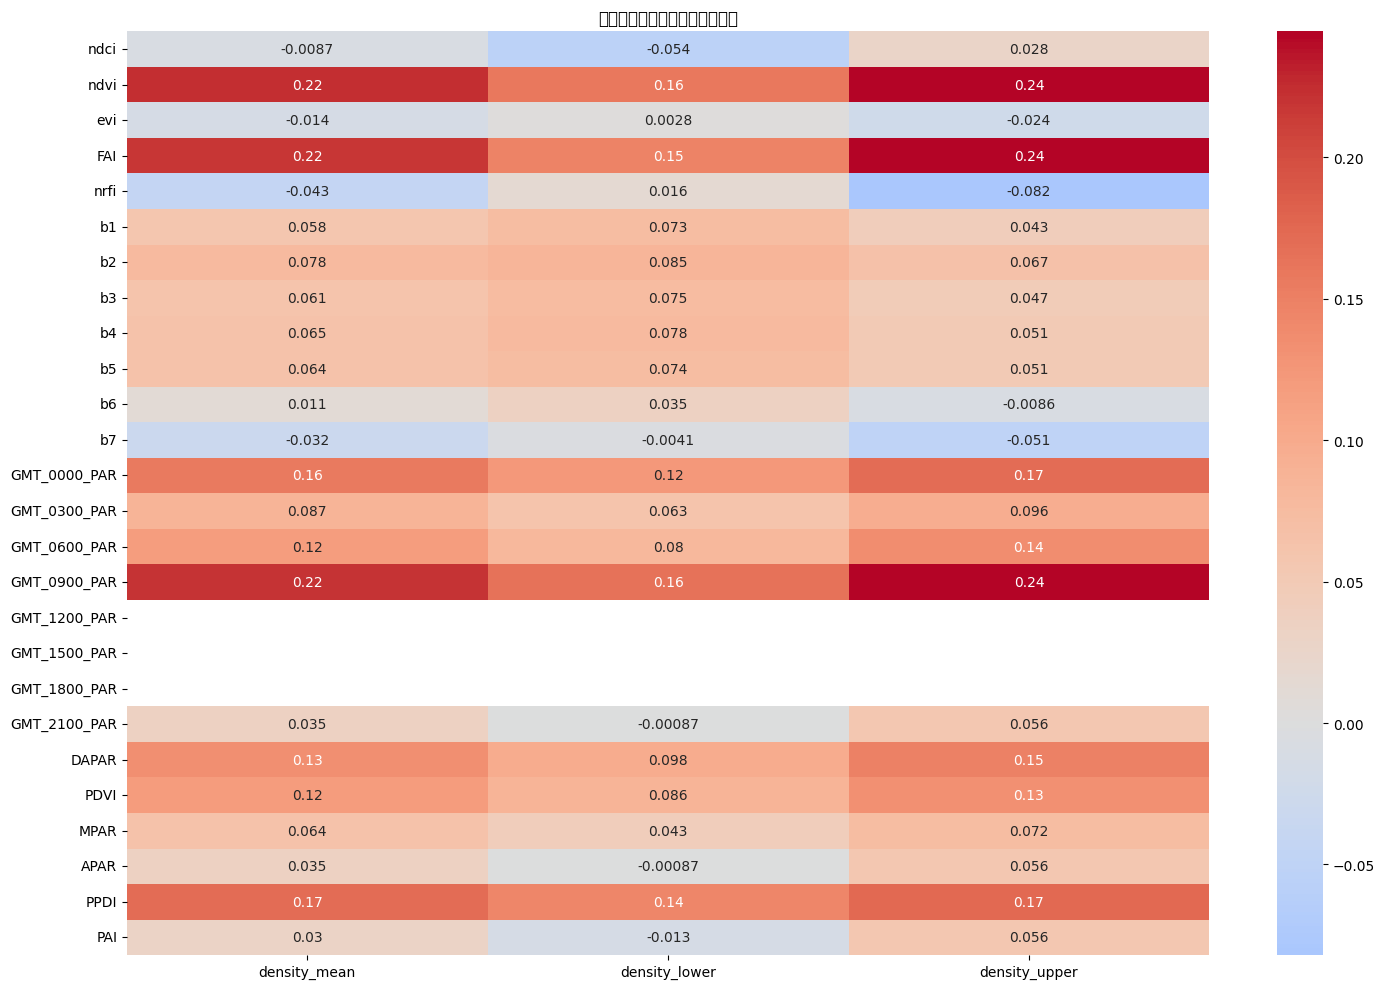

In [4]:
# 将日期列转换为datetime类型
merged_df['date'] = pd.to_datetime(merged_df['date'])

# 定义特征列
features = ['ndci', 'ndvi', 'evi', 'FAI', 'nrfi', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7',
           'GMT_0000_PAR', 'GMT_0300_PAR', 'GMT_0600_PAR', 'GMT_0900_PAR', 'GMT_1200_PAR',
           'GMT_1500_PAR', 'GMT_1800_PAR', 'GMT_2100_PAR', 'DAPAR', 'PDVI', 'MPAR', 'APAR',
           'PPDI', 'PAI']

# 定义目标变量
targets = ['density_mean', 'density_lower', 'density_upper']

# 计算特征和目标之间的相关性
correlations = {}
for target in targets:
    correlations[target] = {}
    for feature in features:
        corr = merged_df[feature].corr(merged_df[target])
        correlations[target][feature] = corr

# 为每个目标变量打印排序后的相关性
for target in targets:
    print(f"\n{target} 与各特征的相关性排序:")
    sorted_corr = sorted(correlations[target].items(), key=lambda x: abs(x[1]), reverse=True)
    for feature, corr in sorted_corr:
        print(f"{feature}: {corr:.4f}")

# 绘制热力图
import seaborn as sns
plt.figure(figsize=(15, 10))
corr_matrix = pd.DataFrame(index=features)
for target in targets:
    corr_matrix[target] = [correlations[target][feature] for feature in features]
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('特征与目标变量的相关性热力图')
plt.tight_layout()
plt.show()
